# AM216 Final-Project: Extend Mini-Project: Predicting drug target interaction using 3D information and predicting ligands that can bind to COVID-19 targets.

Components of X:
*   **Protein**: residues chains (vector length 1000 or other lengths we choose to truncate)
*   **Protein 3D**: contact map of residue distances (vector length around ~20000 after flattening the triangular matrix; need to standardize)
*   **Ligand**: ECFP signature (1024 or 2048)

y: affinity score

Proposed models:
1.   **Mini project**: concatenate protein residue chain and ligant signature to get X
2.   **Just contact map**: concatenate flattened contact map and ligand signature to get X
3.   **Early fusion**: concatenate protein residue chain, flattened contact map and ligand signature to get X
4.   **Late fusion**: train and predict using Model 1 and Model 2 separately, consensus model at the end
5.   **CNN**: Instead of flattening contact map, use convolutaional NN to convolve the map and derive flattened layer
6.   **Pocket**: Instead of using the contact map of the whole protein, get the residues of the just the pocket and get the contact map










## 1. Install Packages

*   Rdkit
*   Deepchem
* Lifelines (calculate CI scores faster)
* Biopython (BioPython's **Bio.PDB** module includes code to load PDB files and calculate the alpha carbon distance between pair of their residues)





In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%%capture cap --no-stderr 
#%%capture is used to suppress the output of this particular cell 

import sys
import time
import os.path
if not os.path.exists('Anaconda3-2019.10-Linux-x86_64.sh'):
  t_start = time.time()
  !wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
  !chmod +x Anaconda3-2019.10-Linux-x86_64.sh
  !bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
  print("Done: Anaconda3", file=sys.stderr)
  t_end = time.time(); print("----Elasped: %f seconds" % (t_end - t_start), file=sys.stderr); t_start = time.time();


  !conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
  
  print("Done: deepchem & rdkit", file=sys.stderr)
  # !conda create -c conda-forge -n my-rdkit-env rdkit;
  # !activate my-rdkit-env; #(OR TRY: !activate my-rdkit-env)
  # !conda install -c conda-forge rdkit;
  # print("Done: rdkit", file=sys.stderr)
  t_end = time.time(); print("----Elasped: %f seconds" % (t_end - t_start), file=sys.stderr); t_start = time.time();

  !pip install lifelines;
  !pip install biopython;
  !pip install mmtf-python;
  print("Done: pip install lifelines & biopython & mmtf-python", file=sys.stderr)
  t_end = time.time(); print("----Elasped: %f seconds" % (t_end - t_start), file=sys.stderr);

Done: Anaconda3
----Elasped: 88.046609 seconds
Done: deepchem & rdkit
----Elasped: 276.369965 seconds
Done: pip install lifelines & biopython & mmtf-python
----Elasped: 9.486234 seconds


In [ ]:
%%capture
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import warnings
warnings.filterwarnings("ignore")

import deepchem as dc
import numpy as np
import os.path
import urllib.request
import pandas as pd
import Bio.PDB
import tensorflow as tf


from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MolFromSmiles
from Bio.PDB.mmtf import MMTFParser

  
import matplotlib.pyplot as plt
import json
import pickle
import networkx as nx
from collections import OrderedDict
from lifelines.utils import concordance_index as ci
from sklearn.model_selection import train_test_split


## 2. Parsing Data
TODO: describe the data we are using.

### 2.1 Parsing PDB data to get the 3D info


In [ ]:
def subsample(dataFrame, n_or_frac):
  if n_or_frac < 1.0:
    return dataFrame.sample(frac = n_or_frac)
  else:
    return dataFrame.sample(n = n_or_frac)

with open('Ligand_Dict.json') as f:
    ligand_dict = json.load(f)
pdb_data = pd.read_csv('PDBbind2019PLdata_cleaned.csv')


pdb_proteinName = np.array(pdb_data['proteinName'])
pdb_affinity = np.array(pdb_data['affinity'])
pdb_ligandName = np.array(pdb_data['ligandName'])


pdb_data_small = pd.read_csv('pdbbind_core_df_cleaned.csv')
pdb_proteinName_small = np.array(pdb_data_small['proteinName'])
pdb_affinity_small = np.array(pdb_data_small['affinity'])
pdb_ligandName_small = np.array(pdb_data_small['ligandName'])


SAMPLE_SIZE = 30
pdb_data_medium = subsample(pdb_data, SAMPLE_SIZE)
pdb_proteinName_medium = np.array(pdb_data_medium['proteinName'])
pdb_affinity_medium = np.array(pdb_data_medium['affinity'])
pdb_ligandName_medium = np.array(pdb_data_medium['ligandName'])

In [ ]:
print("pdb_proteinName.shape:", pdb_proteinName.shape)
print("pdb_affinity.shape:", pdb_affinity.shape)
print("pdb_ligandName.shape:", pdb_ligandName.shape)

print("\n\npdb_proteinName_small.shape:", pdb_proteinName_small.shape)
print("pdb_affinity_small.shape:", pdb_affinity_small.shape)
print("pdb_ligandName_small.shape:", pdb_ligandName_small.shape)

print("\n\npdb_proteinName_medium.shape:", pdb_proteinName_medium.shape)
print("pdb_affinity_medium.shape:", pdb_affinity_medium.shape)
print("pdb_ligandName_medium.shape:", pdb_ligandName_medium.shape)

pdb_proteinName.shape: (15080,)
pdb_affinity.shape: (15080,)
pdb_ligandName.shape: (15080,)


pdb_proteinName_small.shape: (193,)
pdb_affinity_small.shape: (193,)
pdb_ligandName_small.shape: (193,)


pdb_proteinName_medium.shape: (30,)
pdb_affinity_medium.shape: (30,)
pdb_ligandName_medium.shape: (30,)


 #### 3D Representation 1: Contact map

We get the list of residues in each protein and treat that as a single chain to calculate the contact map of this protein. After flattened, the length of the contact map vector should be **O(residue_count * residue_count)**, which is too big for some proteins with large number of residues. Hence, we tried to shrink it by collapsing the 3D coordinates a group of neighboring residues into a single one.

In [ ]:
def filter_residues(residues):
  new_residues = []
  for res in residues:
    if 'CA' in res:
      new_residues.append(res)
  return new_residues

def calc_residue_dist_by_residues(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

#Essentially the Euclidean distance between 2 coords
def calc_residue_dist_by_coords(coord1, coord2) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = coord1 - coord2
    # return np.sqrt(np.sum(diff_vector * diff_vector))
    return np.linalg.norm(diff_vector)



# We expect residue_list1 and residue_list2 to be the same thing: residue list of one protein. Hence the result should be a symmetric matrix, and thus we decided to only calculate the independent entries.
def calc_dist_matrix_by_residues(residue_list1) :
    """Returns a matrix of C-alpha distances between two chains"""
    # answer = np.zeros((len(residue_list1), len(chain_two)), np.float)
    answer = []
    for row, residue_one in enumerate(residue_list1) :
        for col, residue_two in enumerate(residue_list1[row+1:]) :
            answer.append(calc_residue_dist(residue_one, residue_two))
    return answer

def calc_dist_matrix_by_coords(coord_list1) :
    """Returns a matrix of C-alpha distances between two chains"""
    # answer = np.zeros((len(residue_list1), len(chain_two)), np.float)
    answer = []
    for row, coord1 in enumerate(coord_list1) :
        for col, coord2 in enumerate(coord_list1[row+1:]) :
            answer.append(calc_residue_dist_by_coords(coord1, coord2))
    return answer


# Returns the contact map for one protein and prints the info - slow (for demonstration purpose)
# It does the shrinking by shrinking_ratio within each chain (coords from end of chain1 and start of chain 2 will NOT be collapsed together).
def get_protein_contact_map_slow(proteinName, shrinking_ratio=20):
  structure=MMTFParser.get_structure_from_url(proteinName)
  all_chains =structure[0]
  
  #Get 1.residues: list of all residues in the protein
#      2.CA_coord_list has length equal num of chains. 
  residues = []
  CA_coord_list = []

  for idx_chain, chain in enumerate(all_chains):
    CA_curr_chain = []
    for idx_residue, residue in enumerate(chain):
      residues.append(residue)
      if 'CA' in residue:
        CA_curr_chain.append(residue['CA'].coord)
    CA_coord_list.append(CA_curr_chain)
    print("Chain with id %d has %d residues in total, and %d residues with CA." % (idx_chain, len(chain), len(CA_curr_chain)))
  print("\nCount of residues: ", len(residues))
  residues = filter_residues(residues)
  print("Count of residues with CA: ", len(residues))


  # Get coord_list: collapsing list of CA coords of all resiudues with CA in the protein
  coord_list = []
  for CA_curr_chain in CA_coord_list:
    cutting_points = list(np.arange(0,len(CA_curr_chain),shrinking_ratio))
    cutting_points.append(len(CA_curr_chain))
    for i, start in enumerate(cutting_points[:-1]):
      end = cutting_points[i+1]
      coord_list.append(np.mean(CA_curr_chain[start:end],axis=0))
  print("After shrinking, len(coord_list) = ", len(coord_list))


  # Calculate contact_map: pair wise distance of the coords
  contact_map = calc_dist_matrix_by_coords(coord_list)
  print("len(contact_map) = ", len(contact_map))
  return contact_map



# Returns the contact map for one protein and does not print the info - fast
# It does not do the exact shrinking within each chain (That is, coords from end of chain1 and start of chain 2 will be collapsed together).
def get_protein_contact_map(proteinName, shrinking_ratio=20):
  structure=MMTFParser.get_structure_from_url(proteinName)
  all_chains =structure[0]
  
  #Get CA_coord_list: list of CA coords of all residues with CA
  CA_coord_list = []
  for idx_chain, chain in enumerate(all_chains):
    for idx_residue, residue in enumerate(chain):
      if 'CA' in residue:
        CA_coord_list.append(residue['CA'].coord)
  # print("len(CA_coord_list) = ", len(CA_coord_list))

  # Get coord_list: collapsing list of CA coords of all resiudues with CA in the protein
  coord_list = []
  cutting_points = list(np.arange(0,len(CA_coord_list),shrinking_ratio))
  cutting_points.append(len(CA_coord_list))
  for i, start in enumerate(cutting_points[:-1]):
    end = cutting_points[i+1]
    coord_list.append(np.mean(CA_coord_list[start:end],axis=0))
  # print("After shrinking, len(coord_list) = ", len(coord_list))

  # Calculate contact_map: pair wise distance of the coords
  contact_map = calc_dist_matrix_by_coords(coord_list)
  # print("len(contact_map) = ", len(contact_map))

  return contact_map



#Cutting/Padding: use the code from miniproject (how they got 1000-long vector for proteins)
CONTACT_MAP_LENGTH=1000

def cut_or_pad(my_list, length):
    array = np.zeros(length)
    for i, row in enumerate(my_list[:length]): 
        array[i] = row
    return array 

def get_protein_cut_contact_map(proteinName, shrinking_ratio=20):
  contact_map_uncut = get_protein_contact_map(proteinName, shrinking_ratio)
  contact_map = cut_or_pad(contact_map_uncut, CONTACT_MAP_LENGTH)
  return contact_map


Below we are trying to find the fastest way to loop through all residues and get the CA coords from residues with CA.

Conclusion: for all the 5 approaches we tried, including using list comprehensiong and mapping, it still takes about 0.5 sec to calculate the CA coordinate list for 1 protein.

Now we continue processing the contact maps for all proteins. Then we need to do cutting/padding on the data (list of distinct-length lists) so they have equal length in the end (list of equal-length lists)

0,10,20,
Num of contact maps:  30
Min length =  21
Max length =  1225


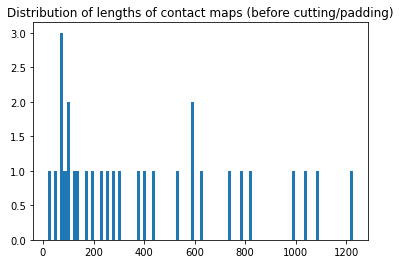

In [ ]:
# Get contact maps for all proteins:
SHRINKING_RATIO = 20 #after exploring, 20 is a good SHRINKING_RATIO to shrink the contact maps into reasonable lengths
contact_maps = []
lens = []

for i in range(len(pdb_proteinName_medium)):
  cm = get_protein_contact_map(pdb_proteinName_medium[i], shrinking_ratio=SHRINKING_RATIO)
  contact_maps.append(cm)
  lens.append(len(cm))
  
  if i %10==0:
    print(i, end=",")
  
print("\nNum of contact maps: ", len(contact_maps))
print("Min length = ", np.min(lens))
print("Max length = ", np.max(lens))
plt.hist(lens, bins=100);
plt.title("Distribution of lengths of contact maps (before cutting/padding)");


In [ ]:
#Cutting/Padding: use the code from miniproject (how they got 1000-long vector for proteins)
CONTACT_MAP_LENGTH=1000


contact_maps = np.array([cut_or_pad(cm, CONTACT_MAP_LENGTH) for cm in contact_maps])
print("contact_maps.shape = ", contact_maps.shape)

contact_maps.shape =  (30, 1000)


Note: After optimizing the code as much as we can, getting the contact maps of proteins is still slow because of the unavoidable calculation to loop through the residues and get the coordinates of their CA (if exists). Each protein takes about **1 sec** to calculate its contact map. This situation is the same for the 2nd 3D representation: using distances from the center.

Hence, we will try to use the medium (sampled from the total 17680 data points) or small data set (from 'pdbbind_core_df_cleaned.csv', which only has 193 data points).

 #### 3D Representation 2: Center Distances (Distances of residues from the center.)
We assume a center for the protein, which is calculated by averaging the 3D coordinates of the residues. Then we use the distances of residues from this center as our 3D representation of this protein. One advantage of this representation is that the final length is of order **O(residue_count)**.


In [ ]:
CENTER_DISTANCES_LENGTH = 1000
def get_protein_center_distances(proteinName, printInfo=False):
  all_chains=MMTFParser.get_structure_from_url(proteinName)[0]
  
  #Step1: Get CA_coord_list: list of CA coords of all residues with CA
  CA_coord_list = []
  for idx_chain, chain in enumerate(all_chains):
    for idx_residue, residue in enumerate(chain):
      if 'CA' in residue:
        CA_coord_list.append(residue['CA'].coord)
  if printInfo:
    print("len(CA_coord_list) = ", len(CA_coord_list))

  #Step2: average coords to get center
  center = np.mean(CA_coord_list, axis=0)
  if printInfo:
    print("center = ", center)


  #Step3: calculate distances from the center
  distances = []
  for coord in CA_coord_list:
    dist = calc_residue_dist_by_coords(center, coord)#Essentially the Euclidean distance between 2 coords
    distances.append(dist)
  if printInfo:
    print("len(distances) = ", len(distances))

  return distances



def get_protein_cut_center_distances(proteinName):
  distances_uncut = get_protein_center_distances(proteinName)
  distances = cut_or_pad(distances_uncut, CENTER_DISTANCES_LENGTH)
  return distances

0,10,20,
Num of contact maps:  30
Min length =  139
Max length =  994


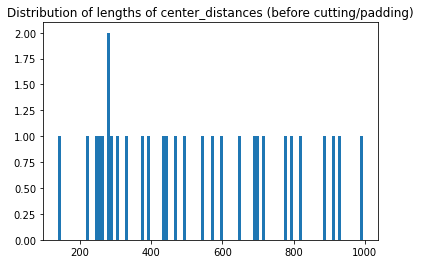

In [ ]:
# Get center_distances for all proteins:

center_distances = []
lens = []
for i in range(len(pdb_proteinName_medium)):
  d = get_protein_center_distances(pdb_proteinName_medium[i])
  center_distances.append(d)
  lens.append(len(d))
  
  if i %10==0:
    print(i, end=",")
  

print("\nNum of contact maps: ", len(center_distances))
print("Min length = ", np.min(lens))
print("Max length = ", np.max(lens))
plt.hist(lens, bins=100);
plt.title("Distribution of lengths of center_distances (before cutting/padding)");


In [ ]:
#Cutting/Padding: use the code from miniproject (how they got 1000-long vector for proteins)
CENTER_DISTANCE_LENGTH=1000

center_distances = np.array([cut_or_pad(d, CENTER_DISTANCE_LENGTH) for d in center_distances])
print("center_distances.shape = ", center_distances.shape)

center_distances.shape =  (30, 1000)


### 2.2 Parse Protein Amino Acid Sequence (length = *1000*)

Now we parse data same as KIBA data in the Mini Project. We get a 1000-long vector representation for each protein. Then we concatenate with the 1000-long vector with 3D information (contact map / center distance). Use the total 2000-long vector as the representation for each protein. [link text](https://)

In [ ]:
amino_acid_dict = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D','ASX':'B','CYS':'C','GLU':'E','GLN':'Q','GLX':'Z','GLY':'G','HIS':'H','ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'}
def get_amino_acid_seq(proteinName):
  structure=MMTFParser.get_structure_from_url(proteinName)
  residues = structure.get_residues()

  seq = ''
  for i, res in enumerate(residues):
    try:
      letter3 = res.get_resname()
      letter1 =  amino_acid_dict[letter3]
      seq += letter1
    except KeyError:
      continue
  return seq


In [ ]:
seq = get_amino_acid_seq(pdb_proteinName[0])
seq

'NGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRARPITSGVFTADYLDKDKYKLVGNIKSVTKEPIEASIKAGALPILTSLAETASGQMLNVNADVAAGELARVFEPLKIVYLNEKGGIINGSTGEKISMINLDEEYDDLMKQSWVKYGTKLKIREIKELLDYLPRSSSVAIINVQDLQKELFTDSGAGTMIRRGYGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRARPITSGVFTADYLDKDKYKLVGNIKSVTKEPIEASIKAGALPILTSLAETASGQMLNVNADVAAGELARVFEPLKIVYLNEKGGIINGSTGEKISMINLDEEYDDLMKQSWVKYGTKLKIREIKELLDYLPRSSSVAIINVQDLQKELFTDSGAGTMIRRGNGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRARPITSGVFTADYLDKDKYKLVGNIKSVTKEPIEASIKAGALPILTSLAETASGQMLNVNADVAAGELARVFEPLKIVYLNEKGGIINGSTGEKISMINLDEEYDDLMKQSWVKYGTKLKIREIKELLDYLPRSSSVAIINVQDLQKELFTDSGAGTMIRRGYGFSATRSTVIQLLNNISTKREVEQYLKYFTSVSQQQFAVIKVGGAIISDNLHELASCLAFLYHVGLYPIVLHGTGPQVNGRLEAQGIEPDYIDGIRITDEHTMAVVRKCFLEQNLKLVTALEQLGVRA

In [ ]:
# for converting protein sequence to categorical format
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:i for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000   # Note that all protein data will have the same length 1000 

def seq_to_cat(proteinSeq):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(proteinSeq[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

# Concordance index evaluation. XM: given function is too slow, we use concordance_index from lifelines.utils to calculate CI score

def get_protein_amino_acids(proteinName):
  seq = get_amino_acid_seq(proteinName)
  vec = seq_to_cat(seq)
  return vec

In [ ]:
vec = seq_to_cat(seq)
vec.shape

(1000,)

### 2.3 Parse Ligand ECFP (length = 1000)
We have obtained the smiles strings from **ligand_dict**. Now we use it to obtain the smiles strings of all ligands and convert them into ECFP vectors.

In [ ]:
list(ligand_dict.values())[:3]

['Cc1c(c2ccc(cc2o1)Oc3ccnc4c3ccc(c4)OCCN5CCOCC5)C(=O)NC',
 'c1ccc(cc1)C[C@@]2(CC[N@@]3CC[C@H](N3C2=O)C(=O)N[C@@H](CCCCN)[C@@H](C(=O)NC4CCCCC4)O)N',
 '[H]/N=C(\\N)/NCCC[C@@H]([C@@H](C(=O)NCCc1ccccc1)O)NC(=O)[C@@H]2CCN3N2C(=O)[C@@](CC3)(Cc4ccccc4)N']

In [ ]:
# smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in ligand_dict.values()])
# print("Total num of ligands: ", len(smiles))
NBITS = 1000

ligands = []
count_invalid = 0

for ligandName in pdb_ligandName_medium:
  smile = ligand_dict[ligandName]
  # print(i, end=",")
  try:
    molecule = MolFromSmiles(smile)
    ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=NBITS).ToBitString()
    ECFP2arr = np.array(list(map(int, ECFP2)))
    ligands.append(ECFP2arr)
  except:
    count_invalid += 1
  # if i % 100==0:
  #   print()

In [ ]:
print("Count = valid:", len(ligands))
print("Count = invalid:", count_invalid)

Count = valid: 30
Count = invalid: 0


In [ ]:
#Assume ligandName is valid (i.e. it can be found in 'ligand_dict' and can be successfully converted to ECFP)
def get_ligand_ECFP(ligandName):
  smile = ligand_dict[ligandName]

  molecule = MolFromSmiles(smile)
  ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits=NBITS).ToBitString()
  ECFP2arr = np.array(list(map(int, ECFP2)))
  return ECFP2arr

### 2.4 Final Representation of Proteins and Ligands

Put everything together.

In [ ]:
# Provides a flexible function to create protein-ligand of different representations
# to create X
def create_pairs(protein_list, ligand_list, protein_func, ligand_func, protein_func_3D=None):
  protein_repr = [protein_func(p) for p in protein_list]
  ligand_repr = [ligand_func(l) for l in ligand_list]

  if protein_func_3D:
    protein_repr_3D = [protein_func_3D(p) for p in protein_list]
  else:
    protein_repr_3D = [[] for p in protein_list]

  pairs = []
  for i in range(len(protein_list)):
    new_pair = np.concatenate((protein_repr[i], protein_repr_3D[i], ligand_repr[i]))
    pairs.append(new_pair)

  return np.array(pairs)

In [ ]:
pdb_proteinName.shape

(15080,)

Import X data we processed using files in 'utils'.

In [50]:
if not os.path.exists('Xdata'):
  !unzip Xdata.zip

X = np.load('Xdata/X.npy')
print("X.shape = ", X.shape)
X_cm = np.load('Xdata/X_cm.npy')
print("X_cm.shape = ", X_cm.shape)
X_cd = np.load('Xdata/X_cd.npy')
print("X_cd.shape = ", X_cd.shape)


X.shape =  (10000, 2000)
X_cm.shape =  (10000, 3000)
X_cd.shape =  (10000, 3000)


In [51]:
print("pdb_affinity.shape = ", pdb_affinity.shape)
indices = np.load('Xdata/X_idx.npy', allow_pickle=True)
print("indices.shape = ",indices.shape)

y = pdb_affinity[indices]
print("y.shape = ", y.shape)

pdb_affinity.shape =  (15080,)
indices.shape =  (10000,)
y.shape =  (10000,)


## 3. Train NN models

In [52]:


# Define the keras model 
def create_keras_model(input_size, output_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(input_size,)))
    if input_size > 2048:
      model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(output_size, activation='linear'))
    return model

def train_test_model(model, pair_tr, affinity_tr, pair_ts, affinity_ts, epochs=20):
  model.compile(optimizer='adam',
              loss= 'mean_squared_error', 
              metrics=['mse']) 

  model.fit(pair_tr, affinity_tr, epochs=epochs, validation_split=0.2)

  print("Evaluation:")
  print('training MSE:', model.evaluate(pair_tr, affinity_tr))
  print('test MSE:', model.evaluate(pair_ts, affinity_ts))

def train_test_model_dc(model_keras, pair_tr, affinity_tr, pair_ts, affinity_ts, epochs=20):
  train_dataset = dc.data.NumpyDataset(X=pair_tr, y=affinity_tr.reshape(len(affinity_tr), 1))
  test_dataset = dc.data.NumpyDataset(X=pair_ts, y=affinity_ts.reshape(len(affinity_ts), 1))
  dc_model = dc.models.KerasModel(model_keras, dc.models.losses.L2Loss()) # we pass the model and a dc loss funciton
  
  dc_model.fit(train_dataset, nb_epoch=epochs)
  metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
  print("\nEvaluation:")
  print('training MSE:', dc_model.evaluate(train_dataset, [metric]))
  print('test MSE:',dc_model.evaluate(test_dataset, [metric]))

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test



In [68]:
# Input: X (vector length=2000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

keras_model = create_keras_model(2000, 1)
train_test_model(keras_model, pair_tr=X_train, affinity_tr=y_train, pair_ts=X_test, affinity_ts=y_test, epochs=100)

X_train.shape =  (8000, 2000)
X_test.shape =  (2000, 2000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 1s 195us/sample - loss: 5.7297 - mean_squared_error: 5.7297 - val_loss: 3.3099 - val_mean_squared_error: 3.3099
Epoch 2/100
6400/6400 [==============================] - 1s 119us/sample - loss: 3.3221 - mean_squared_error: 3.3221 - val_loss: 3.3302 - val_mean_squared_error: 3.3302
Epoch 3/100
6400/6400 [==============================] - 1s 115us/sample - loss: 3.1477 - mean_squared_error: 3.1477 - val_loss: 3.3779 - val_mean_squared_error: 3.3779
Epoch 4/100
6400/6400 [==============================] - 1s 113us/sample - loss: 2.9930 - mean_squared_error: 2.9930 - val_loss: 3.5094 - val_mean_squared_error: 3.5094
Epoch 5/100
6400/6400 [==============================] - 1s 111us/sample - loss: 2.8467 - mean_squared_error: 2.8467 - val_loss: 3.1824 - val_mean_squared_error: 3.182

In [67]:
# Input: X with contact map (vector length=3000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X_cm, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

keras_model = create_keras_model(3000, 1)
train_test_model(keras_model, pair_tr=X_train, affinity_tr=y_train, pair_ts=X_test, affinity_ts=y_test, epochs=100)

X_train.shape =  (8000, 3000)
X_test.shape =  (2000, 3000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 1s 216us/sample - loss: 43.4525 - mean_squared_error: 43.4525 - val_loss: 40.5551 - val_mean_squared_error: 40.5551
Epoch 2/100
6400/6400 [==============================] - 1s 143us/sample - loss: 39.7445 - mean_squared_error: 39.7445 - val_loss: 38.2016 - val_mean_squared_error: 38.2016
Epoch 3/100
6400/6400 [==============================] - 1s 144us/sample - loss: 37.4334 - mean_squared_error: 37.4334 - val_loss: 35.9548 - val_mean_squared_error: 35.9548
Epoch 4/100
6400/6400 [==============================] - 1s 140us/sample - loss: 35.2292 - mean_squared_error: 35.2292 - val_loss: 33.8142 - val_mean_squared_error: 33.8142
Epoch 5/100
6400/6400 [==============================] - 1s 143us/sample - loss: 33.1254 - mean_squared_error: 33.1254 - val_loss: 31.7730 - val_mean_s

In [69]:
# Input: X with center distances (vector length=3000), y(vector length=1000)
X_train, X_test, y_train, y_test = split_data(X_cd, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)

keras_model = create_keras_model(3000, 1)
train_test_model(keras_model, pair_tr=X_train, affinity_tr=y_train, pair_ts=X_test, affinity_ts=y_test, epochs=100)

X_train.shape =  (8000, 3000)
X_test.shape =  (2000, 3000)

y_train.shape =  (8000,)
y_test.shape =  (2000,)
Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 1s 228us/sample - loss: 42.1270 - mean_squared_error: 42.1270 - val_loss: 40.4597 - val_mean_squared_error: 40.4597
Epoch 2/100
6400/6400 [==============================] - 1s 145us/sample - loss: 39.6475 - mean_squared_error: 39.6475 - val_loss: 38.1032 - val_mean_squared_error: 38.1032
Epoch 3/100
6400/6400 [==============================] - 1s 143us/sample - loss: 37.3369 - mean_squared_error: 37.3369 - val_loss: 35.8605 - val_mean_squared_error: 35.8605
Epoch 4/100
6400/6400 [==============================] - 1s 144us/sample - loss: 35.1348 - mean_squared_error: 35.1348 - val_loss: 33.7221 - val_mean_squared_error: 33.7221
Epoch 5/100
6400/6400 [==============================] - 1s 145us/sample - loss: 33.0348 - mean_squared_error: 33.0348 - val_loss: 31.6836 - val_mean_s

Notes: it seems adding 3D info to the representation of protein does make it better!

* X

 **Training: MSE=0.?? (epoch=??); Test: MSE=0.??**

* X contact map

 **Training: MSE=0.?? (epoch=??); Test: MSE=0.??**

* X center distances

 **Training: MSE=0.?? (epoch=??); Test: MSE=0.??**


## 4. Use  your model on COVID-19 protease

Now, use your trained model to identify drugs that could be used as COVID-19 protease inhibitors from these 2111 drugs in the dataset. The sequence of the protease is provided in `6Y84_A.fasta.txt`. You might want to first predict a binding affinity of Ritonavior, a well known HIV drug that binds to HIV protease, to get the sense of a good binding score for this task. SMILES of Ritonavior is provided below.  

In [ ]:
# def protein2vec(protein_seq):
#   return seq_to_cat(protein_seq)

# def drug2vec(drug_smiles, nBits=NBITS):
#   molecule = MolFromSmiles(drug_smiles)
#   ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2, nBits).ToBitString()#XM: default nBits=2048
#   drug_ECFP = np.array(list(map(int, ECFP2)))
#   return drug_ECFP


# # train_dataset = dc.data.NumpyDataset(X=pair_tr, y=affinity_tr.reshape(len(affinity_tr), 1))
# # dc_model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss()) # we pass the model and a dc loss funciton
# # dc_model.fit(train_dataset, nb_epoch=20)
# # print("dc_model is ready!")

# # def protein_drug_predict_dc(protein_vec, drug_vec):#XM: this doesn't work well on HIV
# #   protein_drug_pair = np.concatenate((protein_vec, drug_vec))
# #   protein_drug_pair = protein_drug_pair.reshape((1, len(protein_drug_pair)))

# #   test_dataset = dc.data.NumpyDataset(X=protein_drug_pair)
# #   return dc_model.predict(test_dataset)[0][0]

# keras_model.compile(optimizer='adam',  
#               loss= 'mean_squared_error', 
#               metrics=['mse']) 
# keras_model.fit(pair_tr, affinity_tr, epochs=20)
# print("keras_model is ready!")

# keras_model2.compile(optimizer='adam',  
#               loss= 'mean_squared_error', 
#               metrics=['mse']) 
# keras_model2.fit(pair_tr, affinity_tr, epochs=20)
# print("keras_model2 is ready!")

# def protein_drug_predict(protein_vec, drug_vec, model):
#   protein_drug_pair = np.concatenate((protein_vec, drug_vec))
#   protein_drug_pair = protein_drug_pair.reshape((1, len(protein_drug_pair)))
  
#   return model.predict([protein_drug_pair])[0][0]


In [ ]:
# # HIV: https://www.uniprot.org/uniprot/O90777; https://www.uniprot.org/uniprot/O90777/protvista
# HIV_prot = 'PQVTLWQRPIVTIKIGGQLKEALLDTGADDTVLEEMSLPGKWKPKMIGGIGGFIKVRQYDQVSIEICGHKAIGTVLIGPTPVNIIGRNLLTQLGCTLNF'
# HIV_vec = seq_to_cat(HIV_prot)
# print(HIV_vec.shape)

# ritonavior = 'CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
# ritonavior_ECFP = drug2vec(ritonavior)
# print(ritonavior_ECFP.shape)

In [ ]:
# print("HIV-Ritonavior binding score:")
# HIV_Ritonavior_score = protein_drug_predict(HIV_vec, ritonavior_ECFP, keras_model2)
# HIV_Ritonavior_score

In [ ]:
# print("HIV-AnotherDrug binding scores:")

# HIV_affinities = []
# for i,drug in enumerate(drugs):
#   drug_ECFP = drug2vec(drug)
#   aff = protein_drug_predict(HIV_vec, drug_ECFP, keras_model2)
#   HIV_affinities.append(aff)

# HIV_affinities = np.array(HIV_affinities)
# print(HIV_affinities[:20])
# print(sorted(np.array(list(set(HIV_affinities)))))

# print("\n\nHow many drugs have better bindings with HIV, compared to Ritonavior?")
# print(len(HIV_affinities[HIV_affinities > HIV_Ritonavior_score]) / len(HIV_affinities))
# print("How many drugs have equal bindings with HIV, compared to Ritonavior?")
# print(len(HIV_affinities[HIV_affinities == HIV_Ritonavior_score]) / len(HIV_affinities))

* When using 1000-vector for drugs:

   It seems almost 70% out of the 2111 drugs bind better with HIV, compared to Ritonavior. Thus our model might not be good enough?

* When using 1000-vector for drugs:

  Indeed Ritonavior has the highest binding score, but 94% of the 2111 drugs have the same binding score...


In [ ]:
# COVID_list = []
# with open('data_Drug_target_binding_affinity/data/6Y84_A.fasta.txt', 'r') as f:
#     for line in f:
#         COVID_list.append(line[:-1])

# COVID_seq = ''
# for s in COVID_list[1:]:
#   COVID_seq += s
# print("COVID-19 amino acids sequence: ", COVID_seq)
# COVID_vec = seq_to_cat(COVID_seq)

In [ ]:
# print("COVID-Drug binding scores:")
# COVID_affinities = []
# for i,drug in enumerate(drugs):
#   drug_ECFP = drug2vec(drug)
#   aff = protein_drug_predict(COVID_vec, drug_ECFP, keras_model2)
#   COVID_affinities.append(aff)

# COVID_affinities = np.array(COVID_affinities)
# print(COVID_affinities[:20])

In [ ]:
# print("Below are the Top 5 drug candidates for COVID-19:")
# print("Affinitiy score       Drug smiles: ")
# for idx in np.argsort(COVID_affinities)[-5:]:
#   drug_smiles = drugs[idx]
#   aff_score = COVID_affinities[idx]
#   print(aff_score, "         ",  drug_smiles)